# ATP Tennis Data - Model Tuning For Graident Boosting


In our previous notebooks, we removed some columns from our feature set and found that it had little effect on our model.

In this notebook, we will use the same feature columns and tune our Gradient Boosting model to see if we can improve our performance

### Before tuning

```
Model Score: 0.6903443619176233

ROC/AUC Score: 0.6903161608528401
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```


# Summary of Results




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-reduced_history_matchup"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [4]:
X_train_orig, X_test_orig, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove columns we are not using from this datast

In [6]:
import re

def filter_features(data: pd.DataFrame):
    
    print(f'\nBefore: data.shape {data.shape}')

    new_features = data[["p1_rank", "p2_rank", "p1_seed", "p2_seed", "p1_history_games_won_percentage_diff", "p1_history_sets_won_percentage_diff", 
                        "p1_ht", "p2_ht", "p1_age", "p2_age", "p1_matchup_games_won_percentage", "p2_matchup_games_won_percentage",
                        "p1_history_wins_diff", "tourney_level_label", "p1_matchup_sets_won_percentage", "p2_matchup_sets_won_percentage",
                        "tourney_month", "round_label"]]
             
    surface_cols = [col for col in data.columns if re.match("surface_", col)]
    new_features = pd.concat([new_features, data[surface_cols]], axis=1)

    best_of_cols = [col for col in data.columns if re.match("best_of_", col)]
    new_features = pd.concat([new_features, data[best_of_cols]], axis=1)
             
    player_ioc_cols = [col for col in data.columns if re.match(r"(p1|p2)_ioc_", col)]
    new_features = pd.concat([new_features, data[player_ioc_cols]], axis=1)

    player_id_cols = [col for col in data.columns if re.match(r"(p1|p2)_[\d]+", col)]
    new_features = pd.concat([new_features, data[player_id_cols]], axis=1)

    


    print(f'After: data.shape {new_features.shape}')
    return new_features

X_train = filter_features(X_train_orig)
X_test = filter_features(X_test_orig)


Before: data.shape (44429, 5299)
After: data.shape (44429, 5044)

Before: data.shape (14810, 5299)
After: data.shape (14810, 5044)


In [7]:
print(f'Columns removed: {[col for col in X_test_orig.columns if col not in X_test.columns]}')

Columns removed: ['draw_size', 'tourney_year', 'p1_hand_l', 'p1_hand_r', 'p1_hand_u', 'p2_hand_l', 'p2_hand_r', 'p2_hand_u', 'tourney_id_0301', 'tourney_id_0308', 'tourney_id_0311', 'tourney_id_0314', 'tourney_id_0315', 'tourney_id_0316', 'tourney_id_0319', 'tourney_id_0321', 'tourney_id_0322', 'tourney_id_0328', 'tourney_id_0329', 'tourney_id_0337', 'tourney_id_0341', 'tourney_id_0352', 'tourney_id_0360', 'tourney_id_0375', 'tourney_id_0402', 'tourney_id_0407', 'tourney_id_0410', 'tourney_id_0414', 'tourney_id_0421', 'tourney_id_0424', 'tourney_id_0425', 'tourney_id_0429', 'tourney_id_0439', 'tourney_id_0451', 'tourney_id_0495', 'tourney_id_0496', 'tourney_id_0499', 'tourney_id_0500', 'tourney_id_0506', 'tourney_id_0533', 'tourney_id_0568', 'tourney_id_0605', 'tourney_id_0717', 'tourney_id_0741', 'tourney_id_0773', 'tourney_id_0891', 'tourney_id_1536', 'tourney_id_1720', 'tourney_id_201', 'tourney_id_215', 'tourney_id_224', 'tourney_id_2276', 'tourney_id_237', 'tourney_id_240', 'tourn

# Load our Best Estimater to give us a starting point

In [11]:
report = pd.read_csv(REPORT_FILE)
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == "ohe-reduced_history_matchup")]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)
mw.model.n_estimators_

96

# Initial Hyperparameter Tuning

I tried using grid search for this but Gradient Boosting takes a lot more time than Decision Tree. So I'm going to use Randomized Search to see if this can help us narrow down our search

In [26]:
# from sklearn.model_selection import GridSearchCV

# dt = GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4)
# parameters = {'n_estimators': [100, 200, 300],
#               'min_samples_split': [2, 4, 8, 16],  
#               'min_samples_leaf': [1, 2, 4, 8, 16], 
#               'max_depth': [1, 3, 6, 12, 24], 
#               'max_features': [None, 'sqrt', 'log2'],
#             }
# gscv = GridSearchCV(dt, parameters, cv=5, scoring='accuracy', verbose = 1, refit = True, n_jobs = N_JOBS)
# gscv.fit(X_train, y_train)


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

dt = GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4)
parameters = {'n_estimators': sp_randint(100, 300),
              'min_samples_split': sp_randint(2, 16),  
              'min_samples_leaf': sp_randint(1, 16), 
              'max_depth': sp_randint(1, 24)
            }
gscv = RandomizedSearchCV(dt, parameters, cv=5, scoring='accuracy', verbose = 1, refit = True, n_jobs = N_JOBS, n_iter = 50)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 160.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 681.7min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 894.0min finished


      Iter       Train Loss   Remaining Time 
         1           1.3561           37.03m
         2           1.3303           36.41m
         3           1.3085           36.11m
         4           1.2902           35.98m
         5           1.2744           35.87m
         6           1.2599           35.75m
         7           1.2475           35.70m
         8           1.2369           35.47m
         9           1.2276           35.26m
        10           1.2184           35.02m
        20           1.1584           31.63m
        30           1.1256           28.30m
        40           1.1069           25.56m
        50           1.0951           23.32m


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [27]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [28]:
results_df_orig = pd.DataFrame(gscv.cv_results_)
results_df_orig.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,557.896482,34.108832,0.924587,0.036938,2,11,5,112,"{'max_depth': 2, 'min_samples_leaf': 11, 'min_...",0.668692,0.673081,0.676682,0.678821,0.673495,0.674154,0.003452,23
1,653.786655,106.397704,0.949890,0.079200,3,10,12,216,"{'max_depth': 3, 'min_samples_leaf': 10, 'min_...",0.677808,0.679608,0.681071,0.680959,0.677997,0.679489,0.001395,13
2,1700.629192,183.228641,1.034288,0.081269,14,2,7,263,"{'max_depth': 14, 'min_samples_leaf': 2, 'min_...",0.662390,0.661828,0.675895,0.670831,0.668768,0.667942,0.005301,28
3,1131.202381,233.672664,1.022901,0.197228,23,9,2,119,"{'max_depth': 23, 'min_samples_leaf': 9, 'min_...",0.655751,0.649336,0.660927,0.655188,0.648509,0.653942,0.004568,45
4,959.225951,96.750539,0.894281,0.053381,23,7,5,187,"{'max_depth': 23, 'min_samples_leaf': 7, 'min_...",0.650011,0.647310,0.656313,0.653050,0.653461,0.652029,0.003091,47


In [29]:
results_df_orig.iloc[gscv.best_index_].T

mean_fit_time                                                        694.469
std_fit_time                                                         106.708
mean_score_time                                                     0.657995
std_score_time                                                     0.0756569
param_max_depth                                                            6
param_min_samples_leaf                                                    12
param_min_samples_split                                                   14
param_n_estimators                                                       192
params                     {'max_depth': 6, 'min_samples_leaf': 12, 'min_...
split0_test_score                                                   0.683097
split1_test_score                                                   0.679271
split2_test_score                                                   0.683435
split3_test_score                                                   0.682422

In [30]:
# max_features_list = results_df["param_max_features"].unique()
# replace_dict = { max_features_list[idx]: idx for idx in np.arange(len(max_features_list)) }
# replace_dict

In [31]:
# results_df_orig["param_max_features"] = results_df["param_max_features"].replace(replace_dict)

In [32]:
results_df_orig.iloc[gscv.best_index_].T

mean_fit_time                                                        694.469
std_fit_time                                                         106.708
mean_score_time                                                     0.657995
std_score_time                                                     0.0756569
param_max_depth                                                            6
param_min_samples_leaf                                                    12
param_min_samples_split                                                   14
param_n_estimators                                                       192
params                     {'max_depth': 6, 'min_samples_leaf': 12, 'min_...
split0_test_score                                                   0.683097
split1_test_score                                                   0.679271
split2_test_score                                                   0.683435
split3_test_score                                                   0.682422

In [33]:
gscv.best_score_

0.6816043575142362

In [34]:
gscv.best_params_

{'max_depth': 6,
 'min_samples_leaf': 12,
 'min_samples_split': 14,
 'n_estimators': 192}

In [35]:
gscv.best_index_

36

In [41]:
results_df_orig[["param_n_estimators", "param_max_depth", "param_min_samples_leaf", "param_min_samples_split", "mean_test_score"]].head()

,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score
0,112,2,11,5,0.674154
1,216,3,10,12,0.679489
2,263,14,2,7,0.667942
3,119,23,9,2,0.653942
4,187,23,7,5,0.652029


## Grid Search Results

* max depth -> try 5 to 6
* min sample leaf somewhere between 12 to 15 should give us the best test score
* min sample split somewhre between 14 and 15 should give us the best test score
* n_estimators -> try 120 to 280

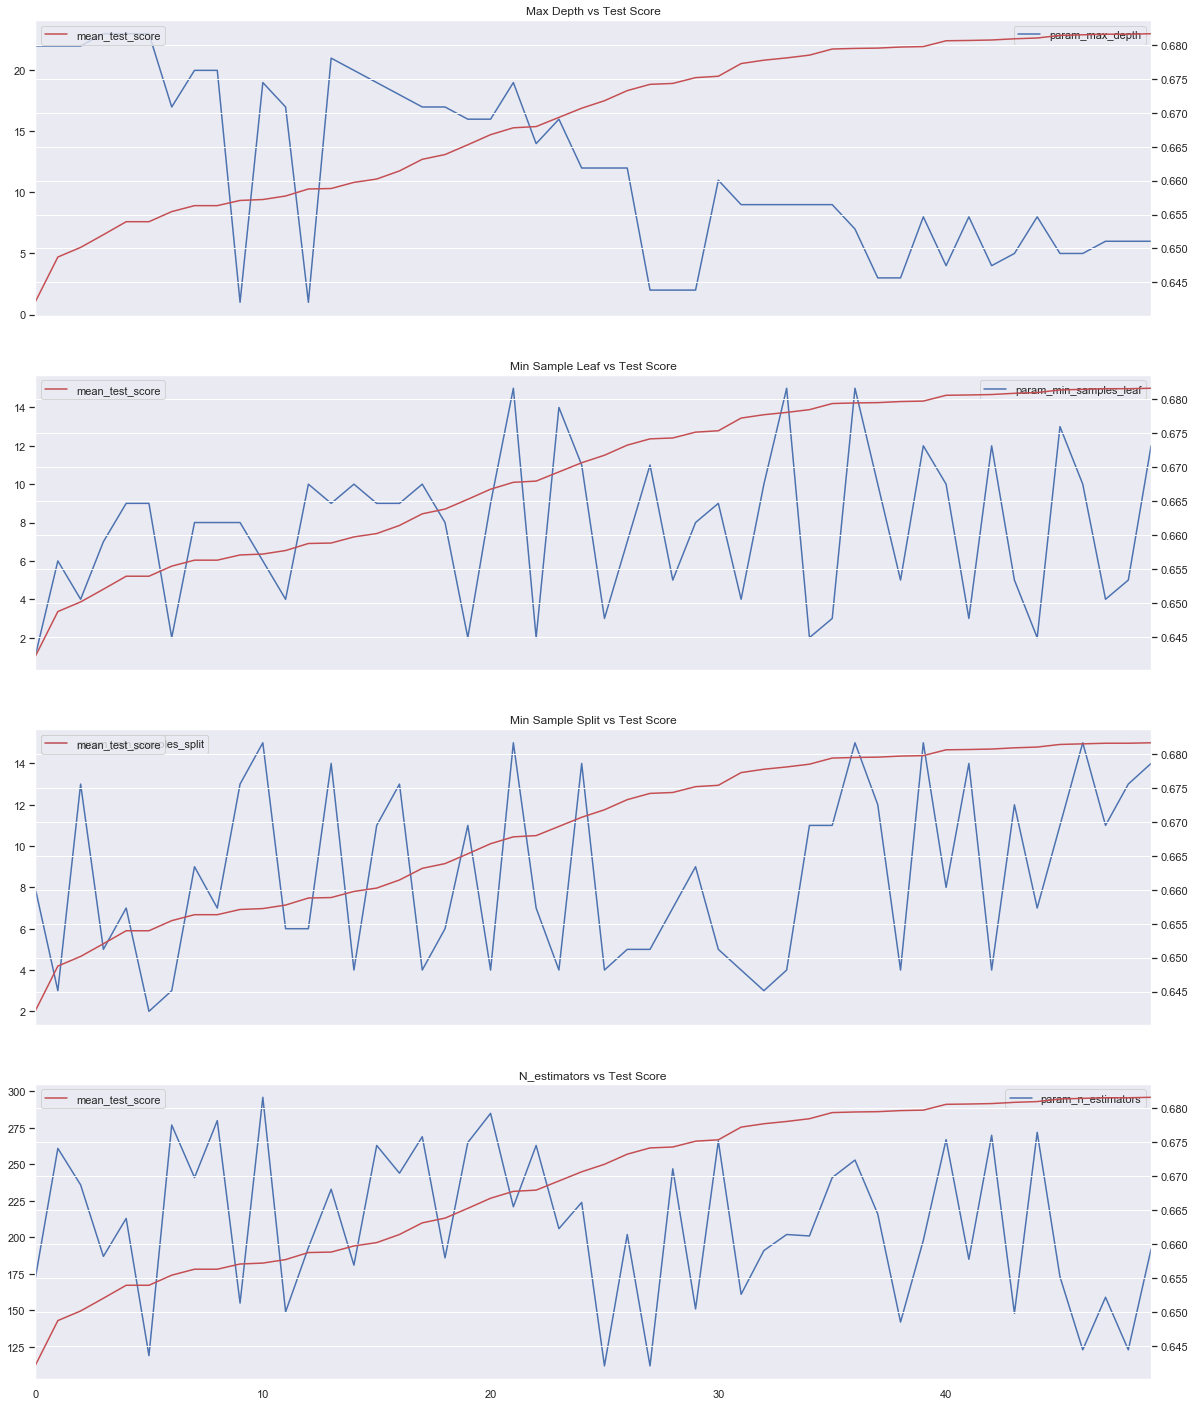

In [50]:
f, a = plt.subplots(4, 1, figsize=(20, 25))


ax = results_df["param_max_depth"].plot(ax=a[0], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.set_title("Max Depth vs Test Score")
ax.grid(False)

ax = results_df["param_min_samples_leaf"].plot(ax=a[1], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.set_title("Min Sample Leaf vs Test Score")
ax.grid(False)


ax = results_df["param_min_samples_split"].plot(ax=a[2], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.set_title("Min Sample Split vs Test Score")
ax.grid(False)

ax = results_df["param_n_estimators"].plot(ax=a[3], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.set_title("N_estimators vs Test Score")
ax.grid(False)



In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
gscv_predict = gscv.best_estimator_.predict(X_test)

In [54]:
accuracy_score(y_test, gscv_predict)

0.6887913571910871

In [55]:
confusion_matrix(y_test, gscv_predict)

array([[5001, 2380],
       [2229, 5200]])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gscv_predict))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68      7381
           1       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810



# We will do another Grid Search to fine tune some of our parameters

In [38]:
gscv.best_params_

{'max_depth': 6,
 'min_samples_leaf': 12,
 'min_samples_split': 14,
 'n_estimators': 192}

In [60]:
# from sklearn.model_selection import GridSearchCV

estimator2 = GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4)
parameters = { 
              'n_estimators': [100, 150, 200, 250, 300],
              'min_samples_leaf': [12, 13, 14, 15], 
              'min_samples_split': [14, 15],  
              'max_depth': [5, 6]
}
gscv2 = GridSearchCV(estimator2, parameters, cv=5, scoring='accuracy', verbose = 1, refit = True, n_jobs = N_JOBS, return_train_score = True)
gscv2.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 137.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 590.4min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 1226.1min finished


      Iter       Train Loss   Remaining Time 
         1           1.3561           26.41m
         2           1.3304           26.14m
         3           1.3086           26.03m
         4           1.2902           25.94m
         5           1.2744           25.87m
         6           1.2599           25.89m
         7           1.2475           25.72m
         8           1.2369           25.42m
         9           1.2277           25.20m
        10           1.2184           24.95m
        20           1.1588           22.80m
        30           1.1258           20.45m
        40           1.1065           18.14m
        50           1.0938           16.10m
        60           1.0847           14.23m


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...nge=4,
                                                  presort='aut

In [61]:
results_df2 = pd.DataFrame(gscv2.cv_results_)
results_df2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,792.300379,170.925492,0.968864,0.026944,5,12,14,100,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.680509,...,0.680231,0.002227,71,0.701432,0.702614,0.701601,0.699041,0.707124,0.702362,0.002654
1,870.778820,202.920213,1.072261,0.087740,5,12,14,150,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.680509,...,0.680231,0.002227,71,0.701432,0.702614,0.701601,0.699041,0.707124,0.702362,0.002654
2,973.161553,197.322636,1.138948,0.245204,5,12,14,200,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.680509,...,0.680231,0.002227,71,0.701432,0.702614,0.701601,0.699041,0.707124,0.702362,0.002654
3,915.741737,134.768698,0.948057,0.056350,5,12,14,250,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.680509,...,0.680231,0.002227,71,0.701432,0.702614,0.701601,0.699041,0.707124,0.702362,0.002654
4,711.655609,118.842212,0.921083,0.051785,5,12,14,300,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.680509,...,0.680231,0.002227,71,0.701432,0.702614,0.701601,0.699041,0.707124,0.702362,0.002654


In [62]:
gscv2.best_score_

0.6824596547300187

In [63]:
gscv2.best_index_

51

In [64]:
gscv2.best_params_

{'max_depth': 6,
 'min_samples_leaf': 13,
 'min_samples_split': 14,
 'n_estimators': 150}

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

gscv2_predict = gscv2.best_estimator_.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, gscv2_predict)}')
print(classification_report(y_test, gscv2_predict))
confusion_matrix(y_test, gscv2_predict)

Accuracy Score: 0.6898717083051992
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      7381
           1       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810



array([[5017, 2364],
       [2229, 5200]])

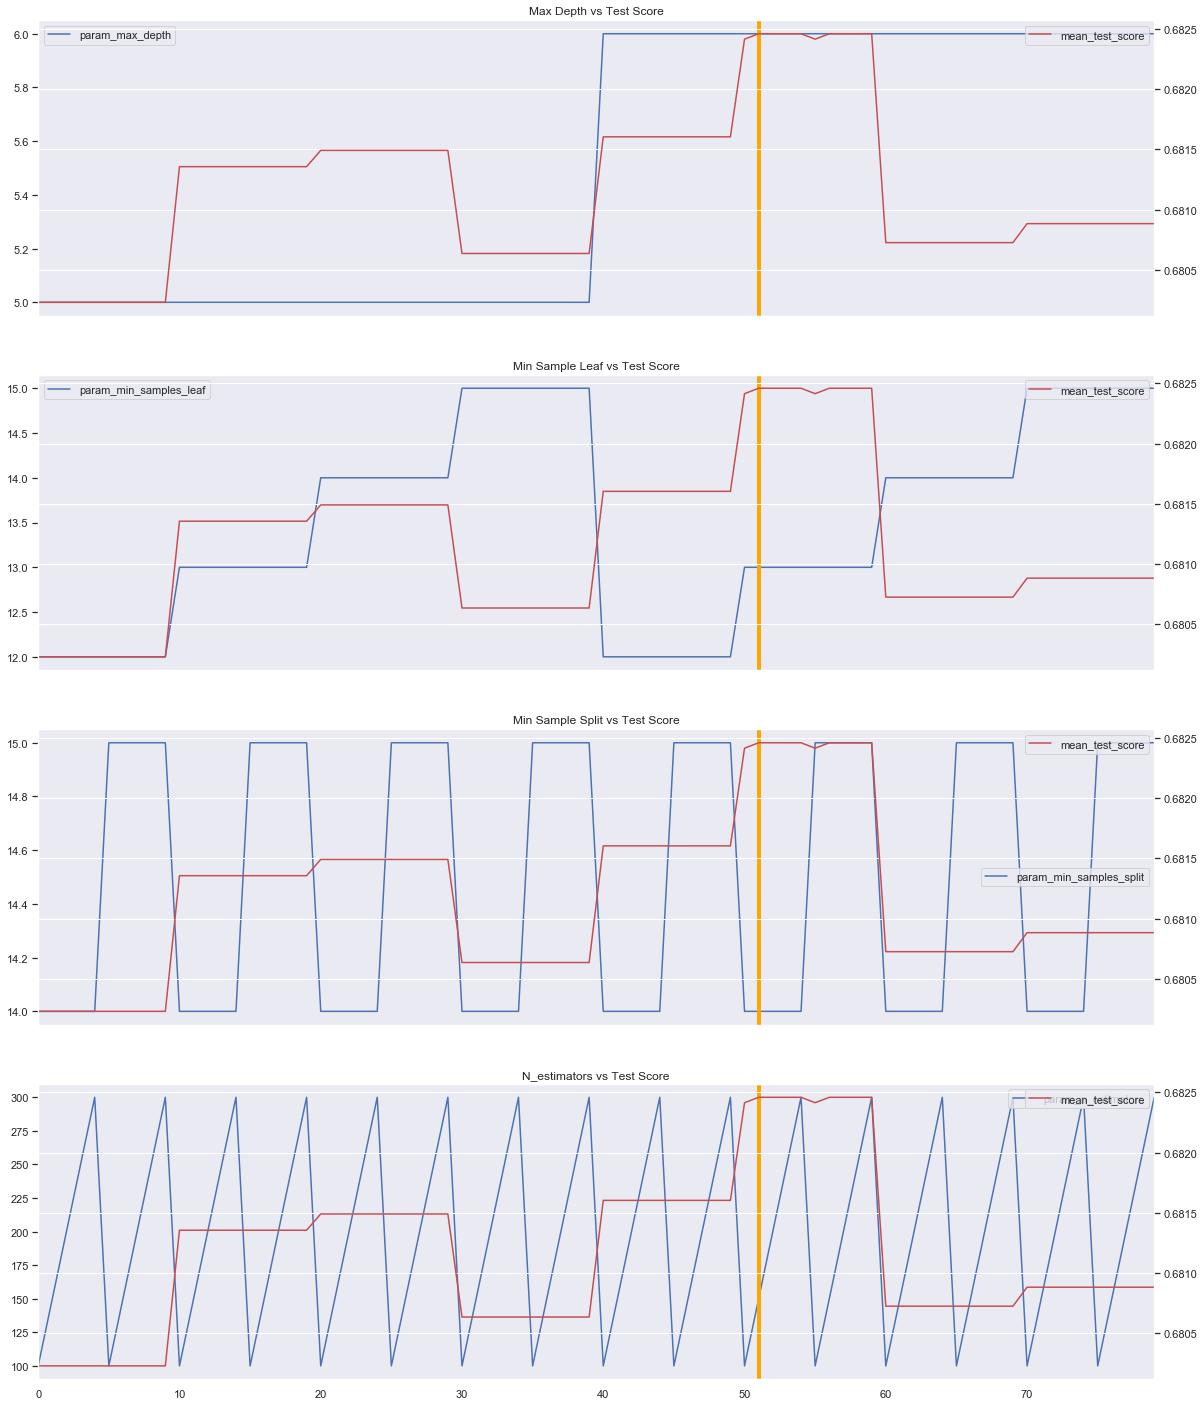

In [76]:
f, a = plt.subplots(4, 1, figsize=(20, 25))


ax = results_df2["param_max_depth"].plot(ax=a[0], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.set_title("Max Depth vs Test Score")
ax.axvline(x=gscv2.best_index_, ymin=0, ymax=results_df2["param_max_depth"].max(), color='orange', linewidth=4)
ax.grid(False)

ax = results_df2["param_min_samples_leaf"].plot(ax=a[1], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(x=gscv2.best_index_, ymin=0, ymax=results_df2["param_min_samples_leaf"].max(), color='orange', linewidth=4)
ax.set_title("Min Sample Leaf vs Test Score")
ax.grid(False)


ax = results_df2["param_min_samples_split"].plot(ax=a[2], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(x=gscv2.best_index_, ymin=0, ymax=results_df2["param_min_samples_split"].max(), color='orange', linewidth=4)

ax.set_title("Min Sample Split vs Test Score")
ax.grid(False)

ax = results_df2["param_n_estimators"].plot(ax=a[3], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(x=gscv2.best_index_, ymin=0, ymax=results_df2["param_n_estimators"].max(), color='orange', linewidth=4)

ax.set_title("N_estimators vs Test Score")
ax.grid(False)



## Let's compare our model accuracy against our test datset

### Best Model from our Original Grid Search

Model Score: 0.6887913571910871

ROC/AUC Score: 0.6887550425653509
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.68      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5001  2380
Win   2229  5200


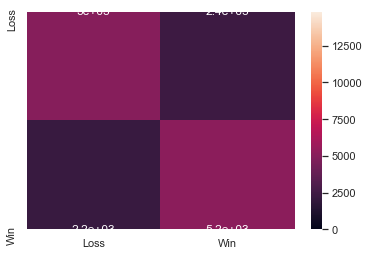

In [79]:
mw = ModelWrapper(gscv.best_estimator_,
                description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)
y_predict_dt = mw.predict()
mw.analyze()

## Model from our 2nd Grid search

Looks like there is a slight improvement in accuracy compared to our first grid search

Although recall for Losses dropped by a percent, our precision actually increased by 1% - meaning that we are slightly worse at identifying losses but when we do, it tends to be more accurate

Win precision also decreased by 1% but our recall for Wins increased by 1% - meaning we are better at identifying wins in our predictions, however, out of these wins there are more false positives

Model Score: 0.6898717083051992

ROC/AUC Score: 0.689838906540422
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5017  2364
Win   2229  5200


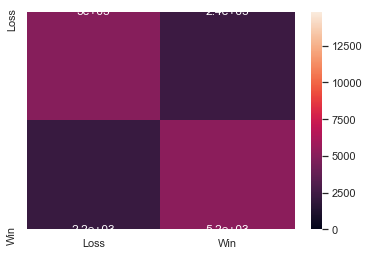

In [77]:
mw2 = ModelWrapper(gscv2.best_estimator_,
                description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)
y_predict_dt2 = mw2.predict()
mw2.analyze()

## Saving off the better model in case we need it later

In [78]:
if mw.accuracy > mw2.accuracy:
    mw.save()
else:
    mw2.save()

Saving report: ../reports/summary.csv
